In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import dask.dataframe as dd
from geopy.distance import geodesic
import string
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, skew

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [104]:
dir = '../csv/'
fname = 'credit_card_fraud_sample_2019_Dec_100K'

*** Went many times from EDA back & forth to preparation, added/removed features... for ease of use I added & packed them all into a pickle file in the preparation stage.

In [108]:
df_BASE = pd.read_pickle(fname + '_prepared.pkl')

In [ ]:
#df_eda.to_csv('credit_card_fraud_sample_2019_Dec_100K_prepared.csv')

In [ ]:
## smaller/faster sample for tests etc...
df_sample = df_BASE.sample(frac=0.8, random_state=42)
print('sample shape: ' + str(df_sample.shape))
df_sample.to_csv('sample_prepared.csv', index=False)

sample shape: (80000, 39)


In [109]:
print('df_eda shape: ' + str(df_BASE.shape))
print(df_BASE.info())

df_eda shape: (100000, 39)
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 38655 to 41847
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     100000 non-null  int64         
 1   ssn                    100000 non-null  object        
 2   cc_num                 100000 non-null  int64         
 3   first                  100000 non-null  object        
 4   last                   100000 non-null  object        
 5   gender                 100000 non-null  int64         
 6   street                 100000 non-null  object        
 7   city                   100000 non-null  object        
 8   state                  100000 non-null  object        
 9   zip                    100000 non-null  int32         
 10  lat                    100000 non-null  float64       
 11  long                   100000 non-null  float64       
 12  city_pop           

In [107]:
df_eda.head()

id        ssn            cc_num        first      last    gender  \
38655  8123390  422-91-6327  3510694985435665  samantha  gonzalez     0     
75696  8123043  422-91-6327  3510694985435665  samantha  gonzalez     0     
32552  8122878  422-91-6327  3510694985435665  samantha  gonzalez     0     
93986  8123042  422-91-6327  3510694985435665  samantha  gonzalez     0     
70538  8122723  422-91-6327  3510694985435665  samantha  gonzalez     0     

                   street               city  state   zip     lat     long    \
38655  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
75696  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
32552  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
93986  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
70538  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   

       city_pop       job          dob      acct_num  \
38655    7765    energy_manager 1941-05-26  18374117   
75696    7765    energy_manager 1941-05-26  18374117   
32552    7765    energy_manager 1941-05-26  18374117   
93986    7765    energy_manager 1941-05-26  18374117   
70538    7765    energy_manager 1941-05-26  18374117   

                 profile                         trans_num              \
38655  adults_50up_female_urban.json  fe3b96184c6f0df6dc0e7167e2c690ad   
75696  adults_50up_female_urban.json  c55f6b59060f8ec42da7e497ccda2a85   
32552  adults_50up_female_urban.json  67cb71be8b60d59d21c45f4dc324cd37   
93986  adults_50up_female_urban.json  cf9972057d72b2a11e5e99816522828c   
70538  adults_50up_female_urban.json  a3fd6137233e2eb3e3fabba64a39f4da   

      trans_date      trans_time       unix_time    category       amt   \
38655 2019-12-08 1900-01-01 07:20:39  1575769839   shopping_pos    2.14   
75696 2019-12-11 1900-01-01 06:28:05  1576025885   shopping_pos    8.21   
32552 2019-12-11 1900-01-01 07:17:51  1576028871   shopping_pos    2.76   
93986 2019-12-18 1900-01-01 03:28:15  1576619895   shopping_pos    1.80   
70538 2019-12-22 1900-01-01 11:15:05  1576993505  entertainment  121.22   

       is_fraud               merchant               merch_lat  merch_long  \
38655      0     fraud_bahringer_schoen_and_corkery  40.496517 -102.800586   
75696      0       fraud_watsica_haag_and_considine  42.065814 -102.130644   
32552      0               fraud_stoltenberg-beatty  40.951743 -102.027276   
93986      0                      fraud_pouros-haag  40.860335 -102.522878   
70538      0         fraud_parker_nolan_and_trantow  41.371826 -103.963709   

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
38655  Midwest          6               1           7         morning_6-12     
75696  Midwest          2               0           6         morning_6-12     
32552  Midwest          2               0           7         morning_6-12     
93986  Midwest          2               0           3       late_night_0-6     
70538  Midwest          6               1          11         morning_6-12     

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
38655  78    senior   Unknown   urban    72.926922         0.000000         
75696  78    senior   Unknown   urban   125.293370        71.123889         
32552  78    senior   Unknown   urban    83.186257         0.829444         
93986  78    senior   Unknown   urban    49.663956       164.173333         
70538  78    senior   Unknown   urban    85.989781       103.780556         

        job_cat    
38655  Management  
75696  Management  
32552  Management  
93986  Management  
70538  Management

***drop the obvious***

*helper Functions*

In [54]:
def plot_categorical(df_in, col, target='is_fraud', top_n=10):
    """
    Plot a bar chart of the counts of the top_n categories in a column.
    """
    # Get the top_n categories
    top_n_cats = df_in[col].value_counts().head(top_n).index
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_in, y=col, order=top_n_cats, hue=target)
    plt.title(f'Count of {col} with Fraud')
    plt.show()

def plot_numerical(df_in, col, target='is_fraud', bins=30):
    """
    Plot a histogram of a numerical column.
    """
    # Create a histogram    
    plt.figure(figsize=(10, 6))
    sns.histplot(df_in, x=col, bins=bins, hue=target, kde=True)
    plt.title(f'{col} Distribution with Fraud')
    plt.show()

def plot_categorical_percent(df_in, col, target='is_fraud', top_n=10):
    """
    Plot a bar chart of the percentage of the top_n categories in a column.
    """
    # Get the top_n categories  
    top_n_cats = df_in[col].value_counts().head(top_n).index
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    (df_in[col].value_counts() / len(df_in)).head(top_n).plot(kind='bar')
    plt.title(f'Percentage of {col}')
    plt.show()

def plot_numerical_percent(df_in, col, target='is_fraud', bins=30):
    """
    Plot a histogram of a numerical column.
    """
    # Create a histogram
    plt.figure(figsize=(10, 6))
    df_in[col].plot(kind='hist', bins=bins)

    plt.title(f'{col} Distribution')
    plt.show()



***Descriptive EDA***

**Preliminary observations:**
-. Categorical features:
-. Numeric features:
-. Unique identifiers:


In [30]:
df_eda.describe()

id          cc_num        gender           zip       \
count  1.000000e+05  1.000000e+05  100000.000000  100000.000000   
mean   1.733159e+07  3.687788e+17       0.482390   51192.157110   
min    1.700000e+01  6.040003e+10       0.000000    1002.000000   
25%    8.656808e+06  3.852401e+13       0.000000   27565.000000   
50%    1.732208e+07  3.506601e+15       0.000000   48150.000000   
75%    2.598662e+07  4.593295e+15       1.000000   78363.000000   
max    3.463594e+07  4.999689e+18       1.000000   99929.000000   
std    1.000948e+07  1.232144e+18       0.499692   29728.394249   

            lat           long         city_pop               dob              \
count  100000.000000  100000.000000  1.000000e+05                      100000   
mean       37.581594     -91.996846  2.933952e+05  1978-11-01 20:48:46.080000   
min        19.589300    -163.118900  4.400000e+01         1928-01-05 00:00:00   
25%        33.897200     -98.643300  1.785300e+04         1967-08-19 18:00:00   
50%        38.565600     -87.175700  6.076300e+04         1981-07-25 12:00:00   
75%        41.224750     -79.939600  2.337170e+05         1992-11-15 00:00:00   
max        66.693300     -67.407300  2.906700e+06         2008-11-24 00:00:00   
std         5.184296      16.506715  5.648002e+05                         NaN   

         acct_num             trans_date            \
count  1.000000e+05                         100000   
mean   4.971789e+11  2019-12-16 01:24:10.080000256   
min    1.837412e+07            2019-12-01 00:00:00   
25%    2.443508e+11            2019-12-08 00:00:00   
50%    4.949888e+11            2019-12-16 00:00:00   
75%    7.501972e+11            2019-12-24 00:00:00   
max    9.999583e+11            2019-12-31 00:00:00   
std    2.895940e+11                            NaN   

                trans_time              unix_time        amt       \
count                         100000  1.000000e+05  100000.000000   
mean   1900-01-01 14:02:32.631059968  1.576490e+09      67.459051   
min              1900-01-01 00:00:01  1.575139e+09       1.000000   
25%              1900-01-01 09:06:24  1.575797e+09       7.490000   
50%       1900-01-01 15:00:56.500000  1.576439e+09      34.500000   
75%    1900-01-01 19:31:22.249999872  1.577136e+09      79.280000   
max              1900-01-01 23:59:59  1.577817e+09   11078.860000   
std                              NaN  7.680531e+05     164.191618   

         is_fraud       merch_lat     merch_long    trans_day_of_week  \
count  100000.000000  100000.000000  100000.000000    100000.000000     
mean        0.002890      37.584537     -91.997536         3.561250     
min         0.000000      18.695408    -164.061908         0.000000     
25%         0.000000      33.865926     -98.986065         2.000000     
50%         0.000000      38.453030     -87.053708         4.000000     
75%         0.000000      41.306195     -79.671186         5.000000     
max         1.000000      66.482129     -66.921783         6.000000     
std         0.053681       5.214922      16.515207         2.036465     

        is_weekend     trans_hour         age         distance     \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.416490      13.541860      40.663180      76.406411   
min         0.000000       0.000000      11.000000       0.319967   
25%         0.000000       9.000000      27.000000      55.484537   
50%         0.000000      15.000000      38.000000      78.642078   
75%         1.000000      19.000000      52.000000      98.820498   
max         1.000000      23.000000      91.000000     147.041384   
std         0.492979       6.615544      17.850472      29.269574   

       time_since_last_trans  
count      100000.000000      
mean           74.770042      
min             0.000000      
25%             4.850694      
50%            44.513333      
75%           109.631319      
max           722.458333      
std            93.018155

In [22]:
df_eda['is_fraud'].value_counts()

is_fraud
0    99711
1      289
Name: count, dtype: int64

In [33]:
df_eda.columns

Index(['id', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num',
       'profile', 'trans_num', 'trans_date', 'trans_time', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'region', 'trans_day_of_week', 'is_weekend', 'trans_hour',
       'trans_time_segment', 'age', 'age_group', 'cc_type', 'area_cat',
       'distance', 'time_since_last_trans', 'job_cat'],
      dtype='object')

In [ ]:
cols_of_interest = ['gender', 'state', 'city_pop', 'job', 'dob', 'acct_num', 'trans_date', 'trans_time', 'unix_time', 'category', 
       'amt', 'is_fraud', 'region', 'trans_day_of_week', 'is_weekend', 'trans_hour','trans_time_segment', 
       'age', 'age_group', 'cc_type', 'area_cat', 'distance', 'time_since_last_trans', 'job_cat']

In [32]:
from autoviz.AutoViz_Class import AutoViz_Class
%matplotlib inline

In [43]:
#

df_subset = df_eda[cols_of_interest]
df_subset.to_csv(fname + '_subset.csv', index=False)
df_subset.head()

gender state  city_pop       job          dob      acct_num trans_date  \
38655     0     NE     7765    energy_manager 1941-05-26  18374117 2019-12-08   
75696     0     NE     7765    energy_manager 1941-05-26  18374117 2019-12-11   
32552     0     NE     7765    energy_manager 1941-05-26  18374117 2019-12-11   
93986     0     NE     7765    energy_manager 1941-05-26  18374117 2019-12-18   
70538     0     NE     7765    energy_manager 1941-05-26  18374117 2019-12-22   

           trans_time       unix_time    category       amt   is_fraud  \
38655 1900-01-01 07:20:39  1575769839   shopping_pos    2.14      0      
75696 1900-01-01 06:28:05  1576025885   shopping_pos    8.21      0      
32552 1900-01-01 07:17:51  1576028871   shopping_pos    2.76      0      
93986 1900-01-01 03:28:15  1576619895   shopping_pos    1.80      0      
70538 1900-01-01 11:15:05  1576993505  entertainment  121.22      0      

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
38655  Midwest          6               1           7         morning_6-12     
75696  Midwest          2               0           6         morning_6-12     
32552  Midwest          2               0           7         morning_6-12     
93986  Midwest          2               0           3       late_night_0-6     
70538  Midwest          6               1          11         morning_6-12     

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
38655  78    senior   Unknown   urban    72.926922         0.000000         
75696  78    senior   Unknown   urban   125.293370        71.123889         
32552  78    senior   Unknown   urban    83.186257         0.829444         
93986  78    senior   Unknown   urban    49.663956       164.173333         
70538  78    senior   Unknown   urban    85.989781       103.780556         

        job_cat    
38655  Management  
75696  Management  
32552  Management  
93986  Management  
70538  Management

Shape of your Data Set loaded: (100000, 24)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    23 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification problem #####################
    All variables classified into correct types.


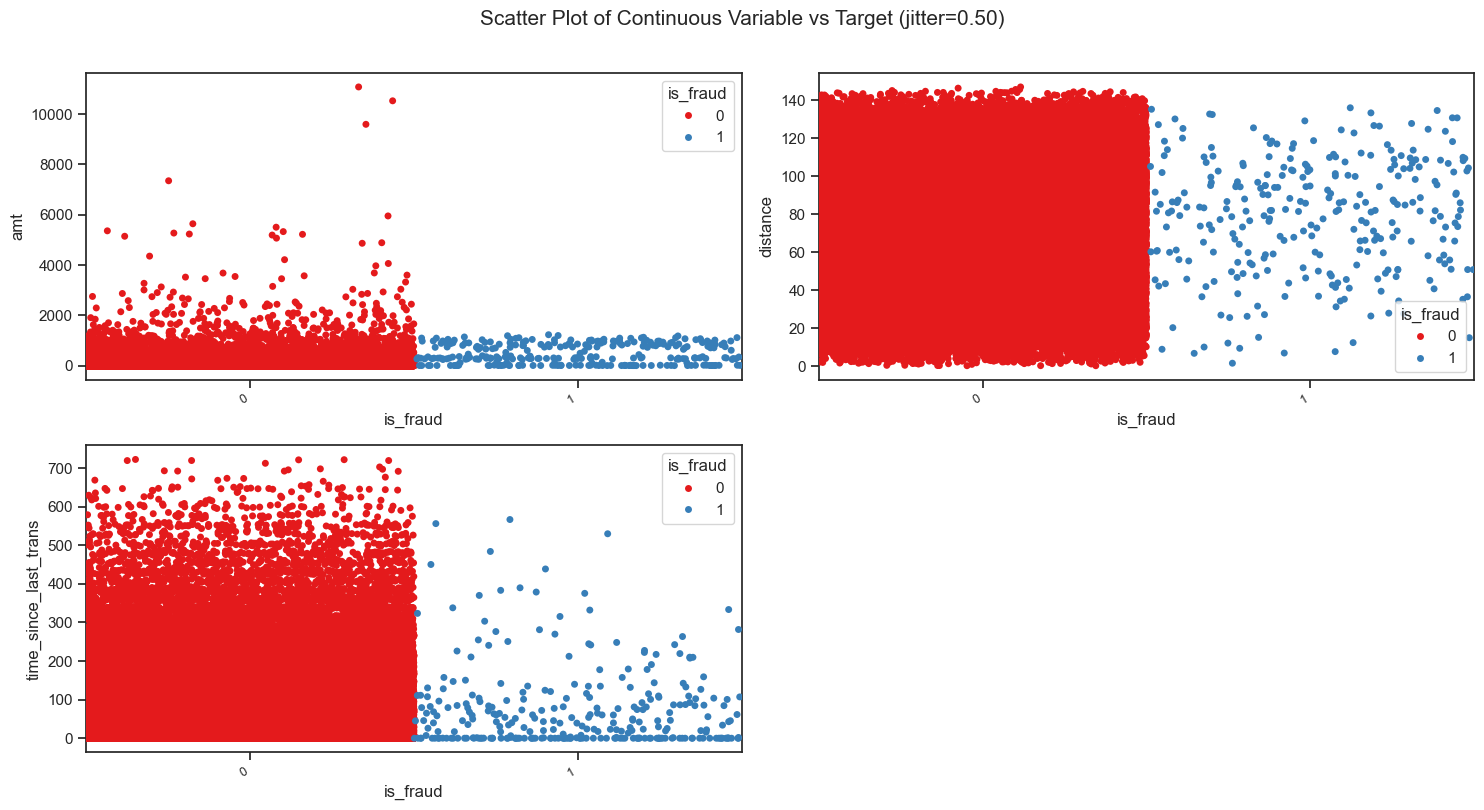

Total Number of Scatter Plots = 6


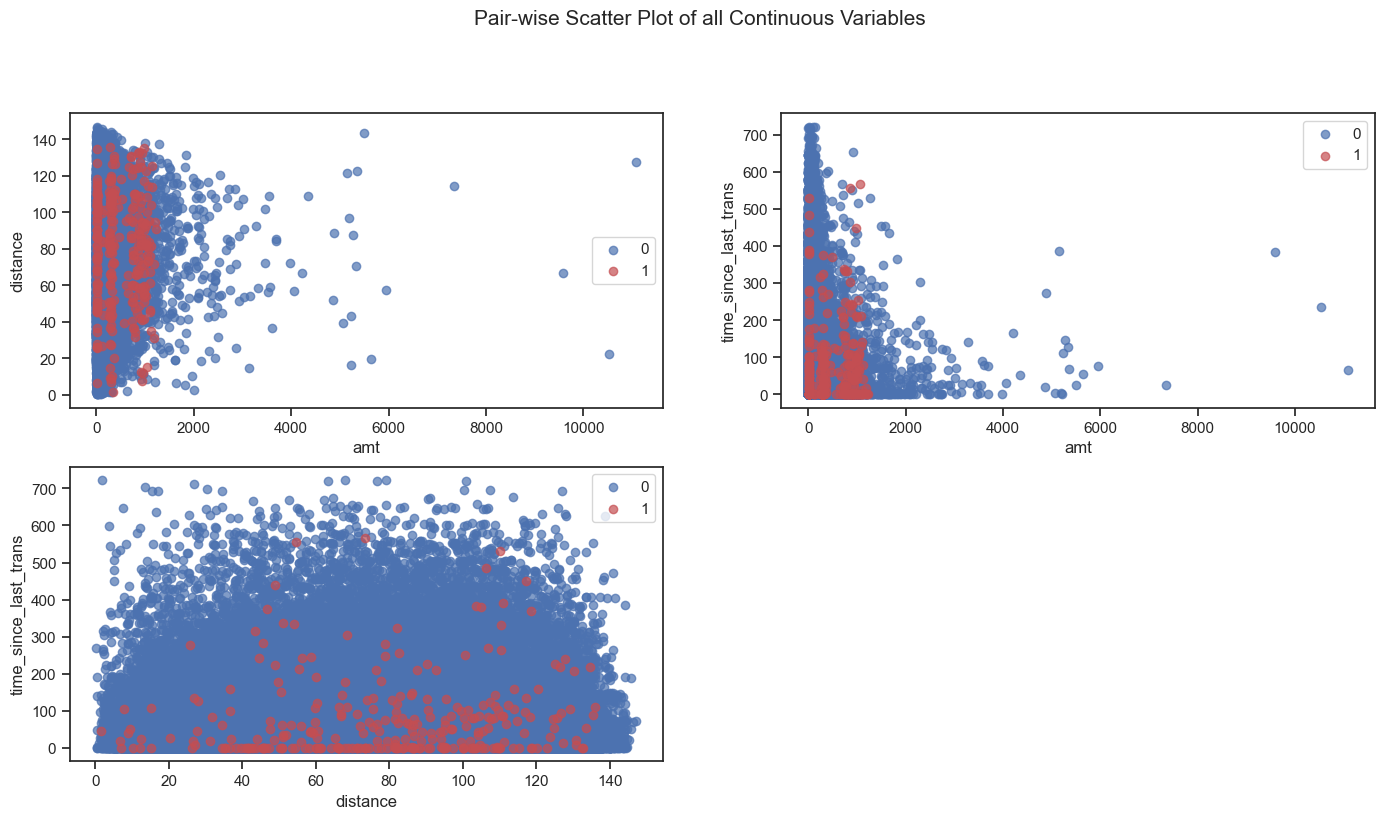

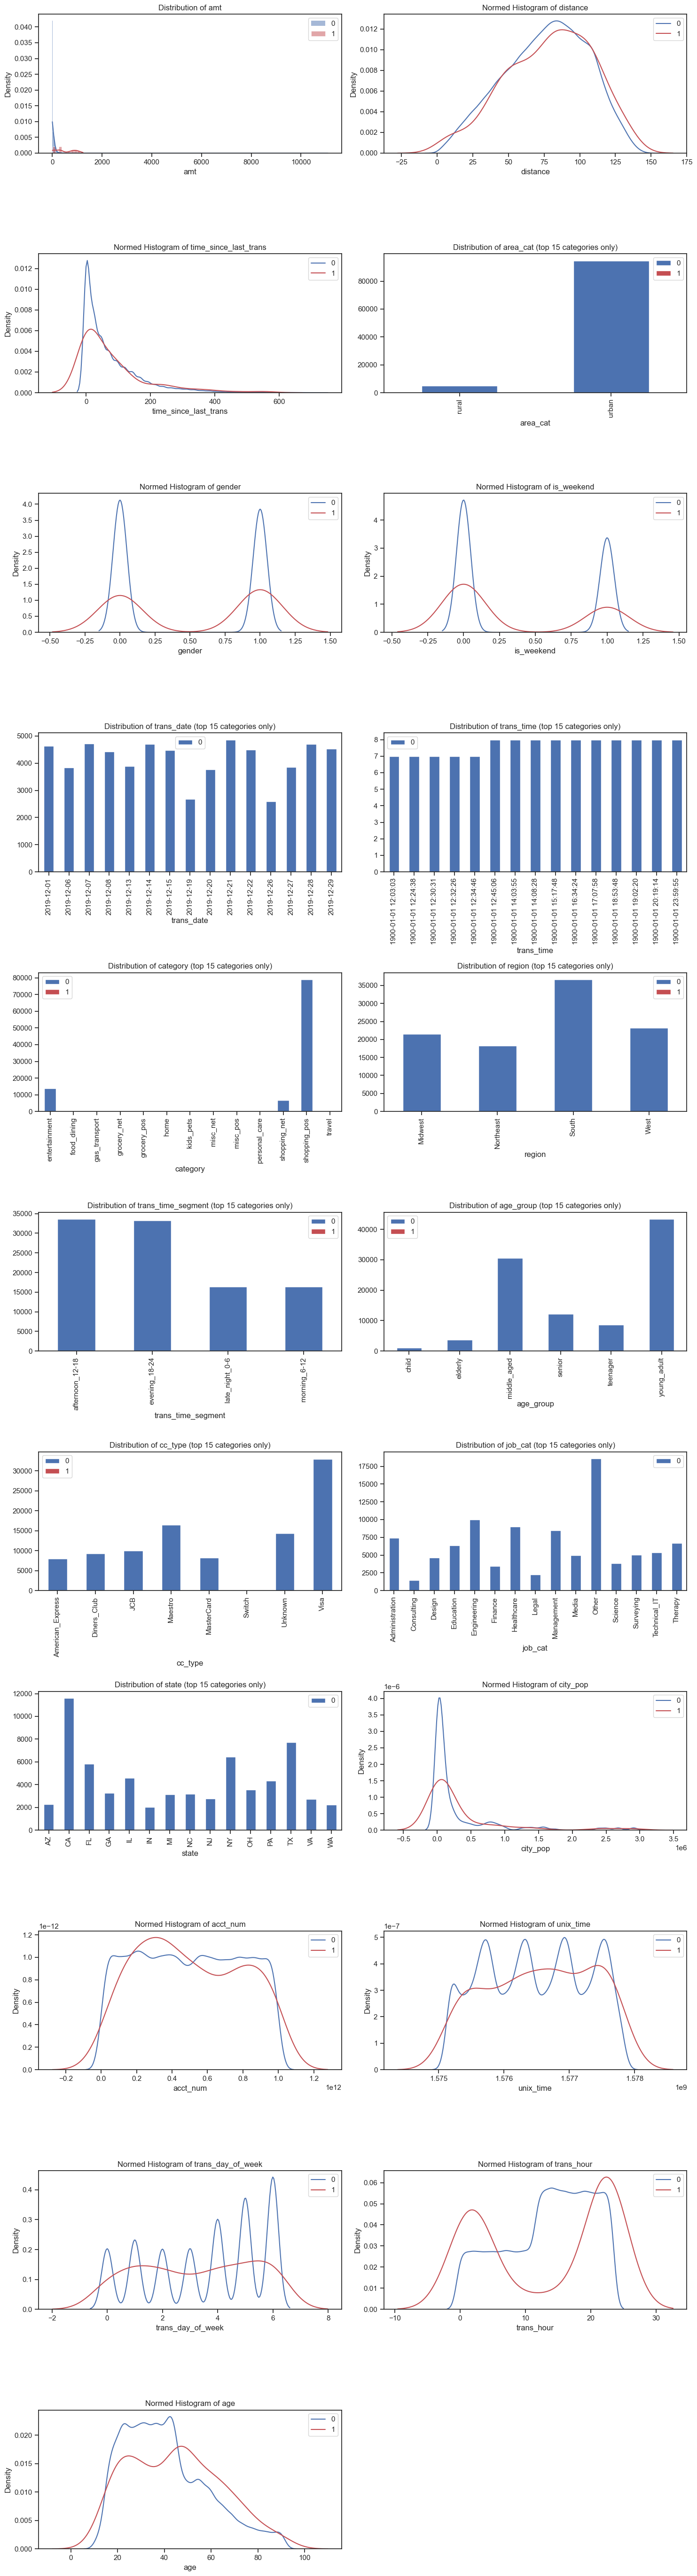

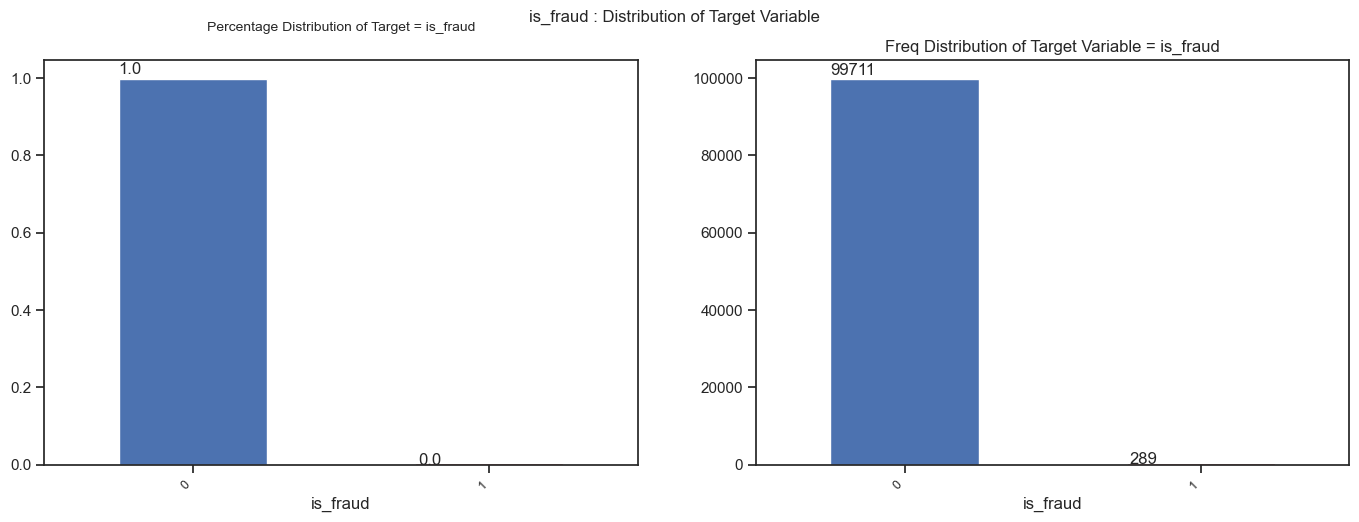

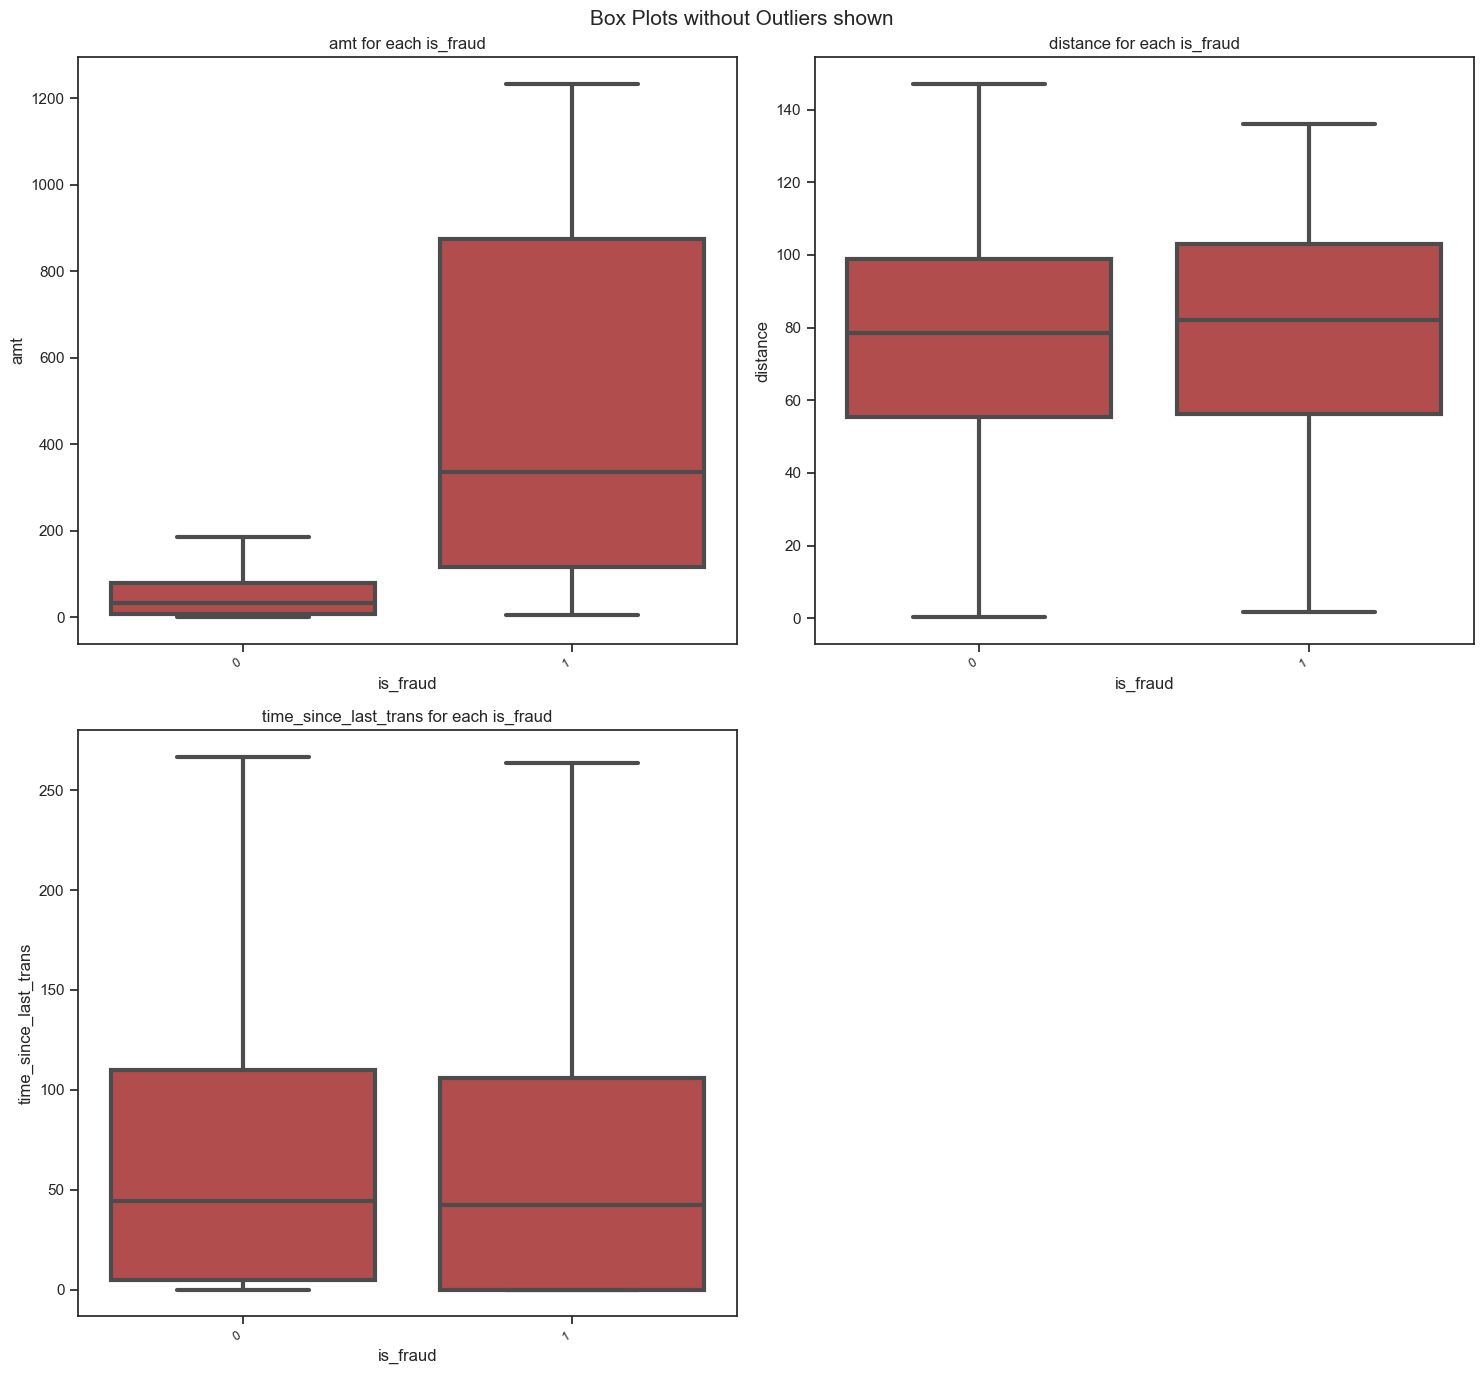

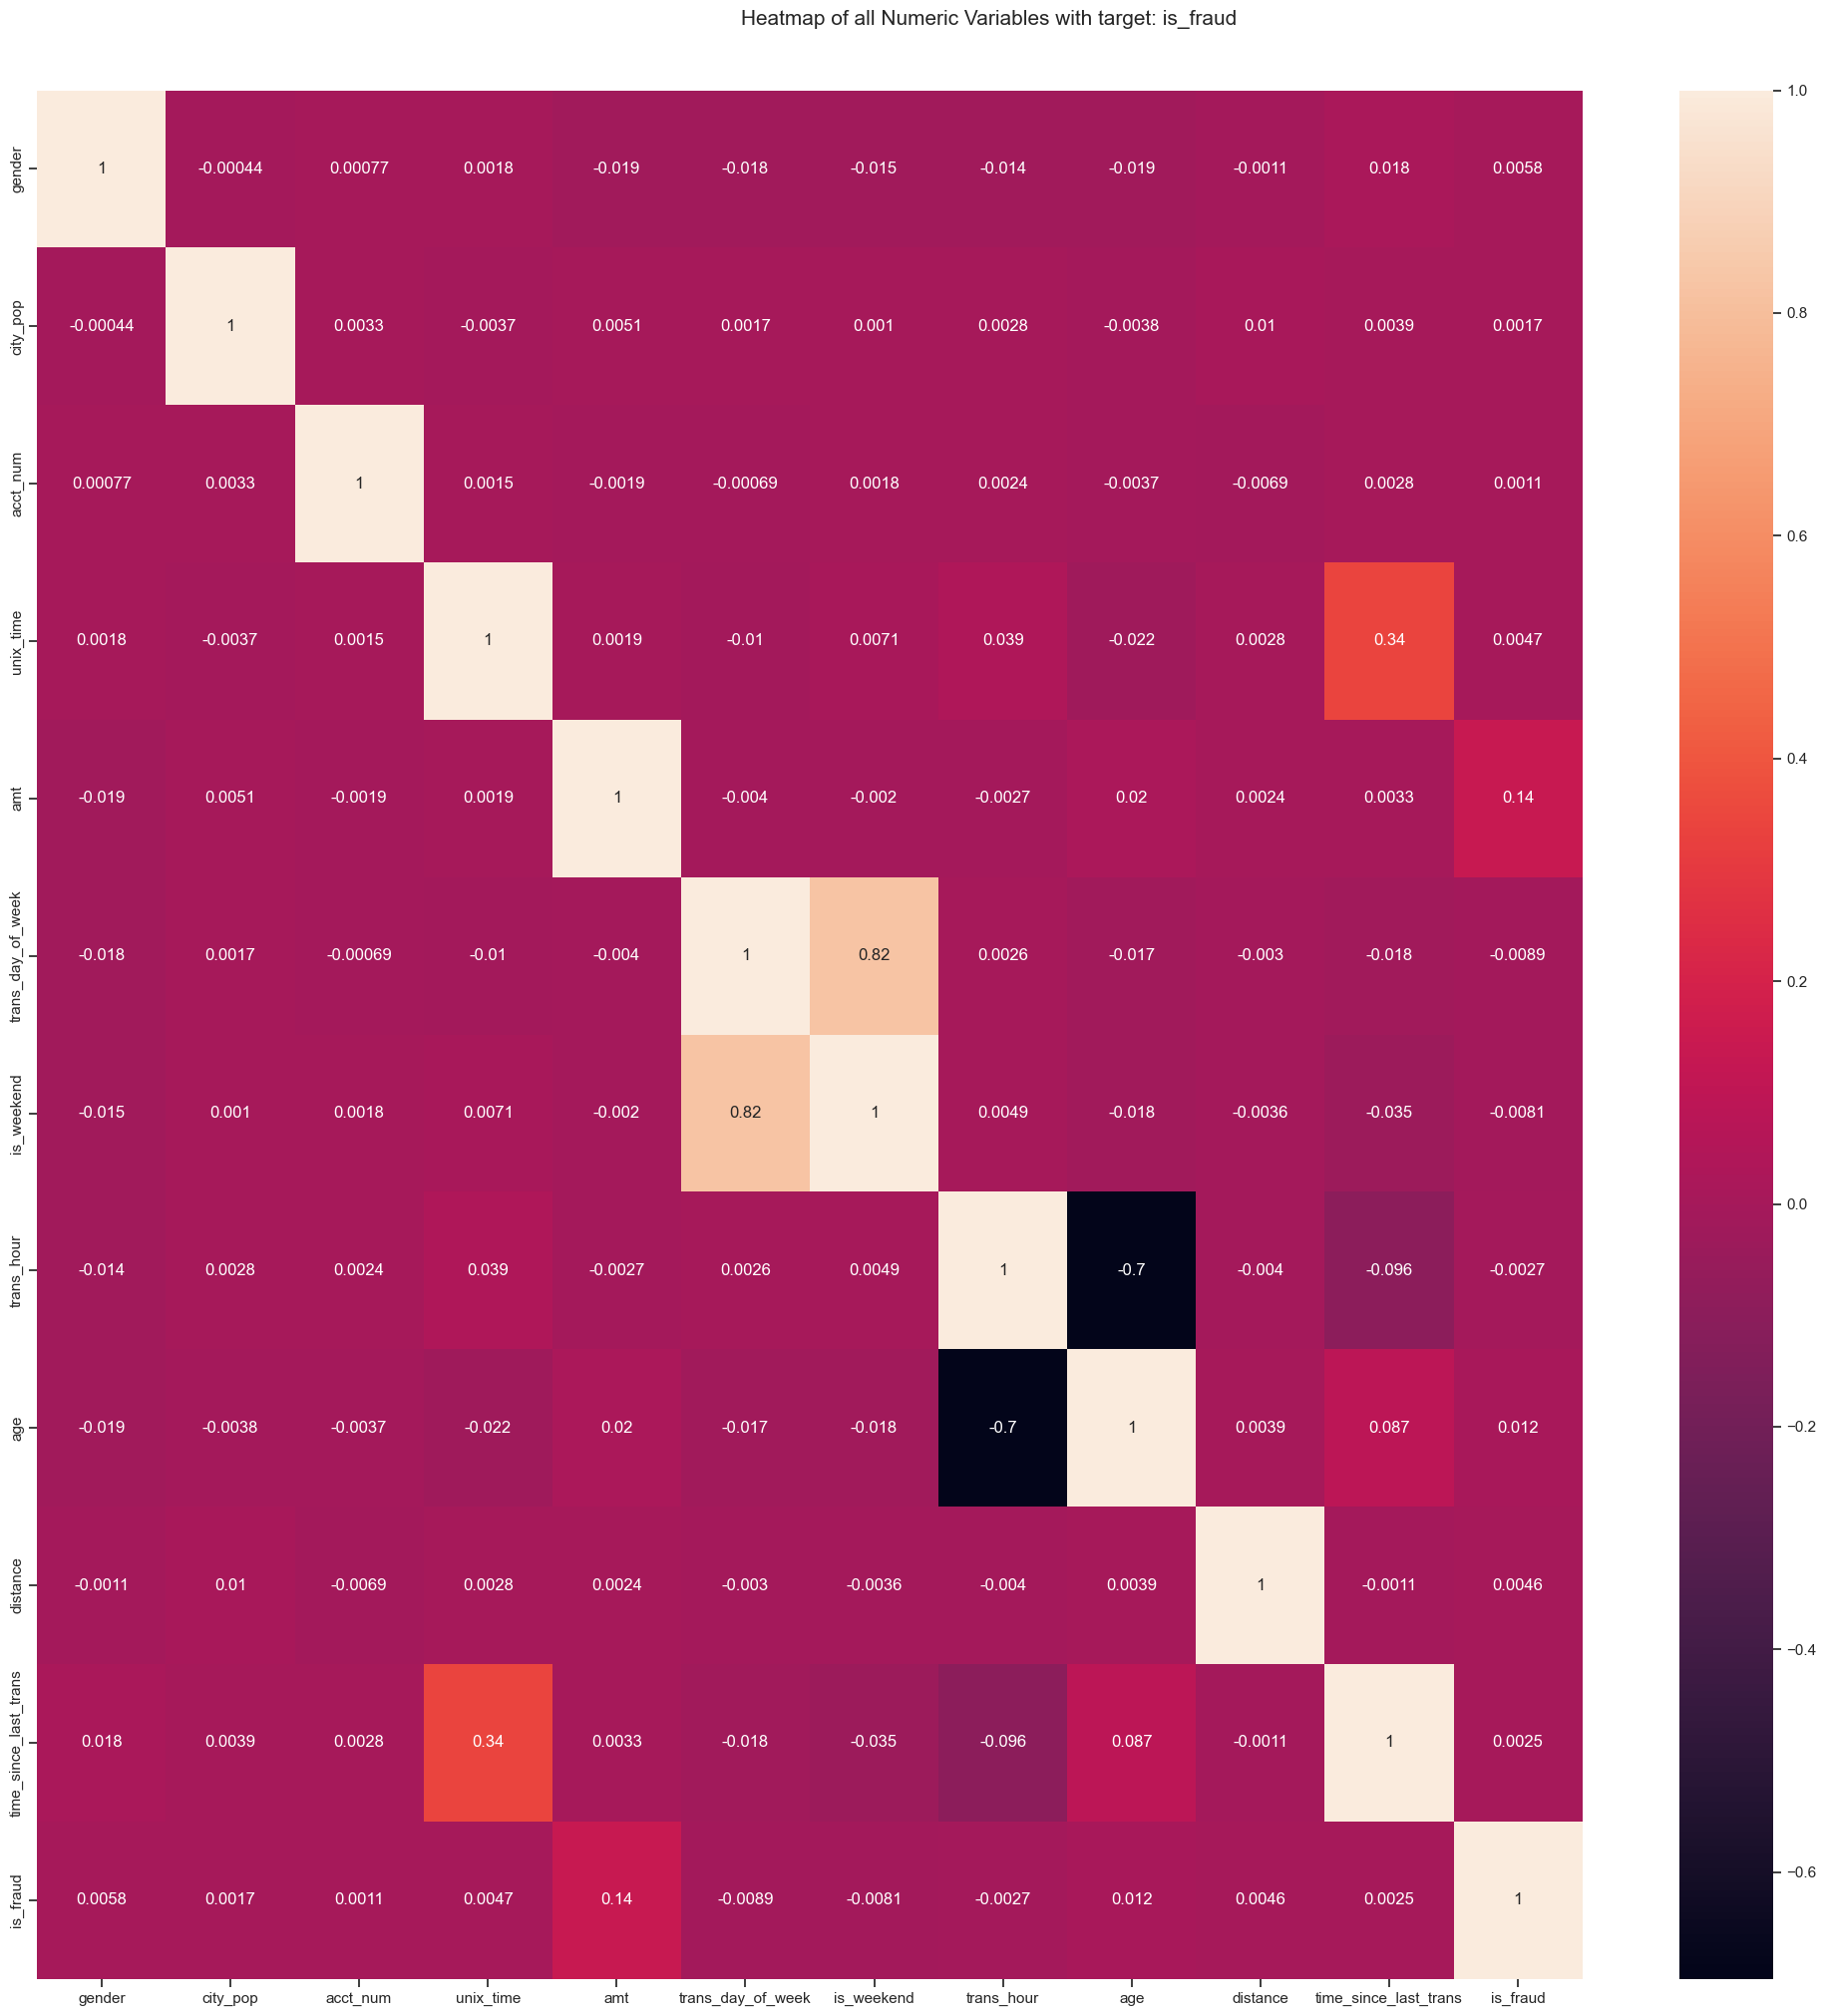

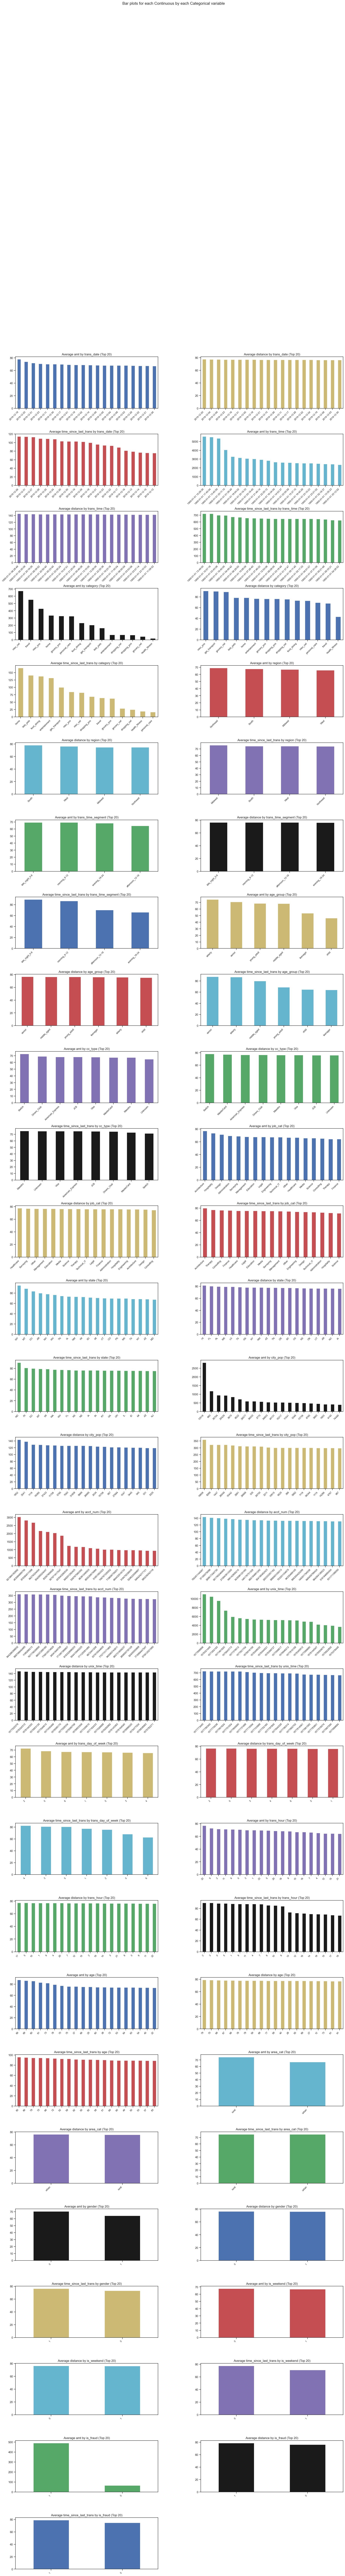

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\DCervin\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nlt

Could not draw wordcloud plot for dob. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for job. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

All Plots done
Time to run AutoViz = 28 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


gender state  city_pop             job                  dob      \
0         0     NE      7765                energy_manager  1941-05-26   
1         0     NE      7765                energy_manager  1941-05-26   
2         0     NE      7765                energy_manager  1941-05-26   
3         0     NE      7765                energy_manager  1941-05-26   
4         0     NE      7765                energy_manager  1941-05-26   
...       ...   ...       ...                          ...         ...   
99995     1     AL      9897   designer_industrial/product  1958-06-07   
99996     1     AL      9897   designer_industrial/product  1958-06-07   
99997     0     NY    177756              graphic_designer  1983-03-28   
99998     0     NY    177756              graphic_designer  1983-03-28   
99999     0     NY    177756              graphic_designer  1983-03-28   

         acct_num    trans_date      trans_time        unix_time  \
0          18374117  2019-12-08  1900-01-01 07:20:39  1575769839   
1          18374117  2019-12-11  1900-01-01 06:28:05  1576025885   
2          18374117  2019-12-11  1900-01-01 07:17:51  1576028871   
3          18374117  2019-12-18  1900-01-01 03:28:15  1576619895   
4          18374117  2019-12-22  1900-01-01 11:15:05  1576993505   
...             ...         ...                  ...         ...   
99995  999889447425  2019-12-06  1900-01-01 10:21:20  1575607880   
99996  999889447425  2019-12-14  1900-01-01 00:14:26  1576262666   
99997  999958349264  2019-12-13  1900-01-01 15:09:43  1576229983   
99998  999958349264  2019-12-21  1900-01-01 13:32:03  1576915323   
99999  999958349264  2019-12-30  1900-01-01 17:17:25  1577706445   

         category       amt    region    trans_day_of_week  is_weekend  \
0       shopping_pos    2.14    Midwest          6               1       
1       shopping_pos    8.21    Midwest          2               0       
2       shopping_pos    2.76    Midwest          2               0       
3       shopping_pos    1.80    Midwest          2               0       
4      entertainment  121.22    Midwest          6               1       
...              ...     ...        ...                ...         ...   
99995   shopping_pos    2.94      South          4               0       
99996   shopping_pos    6.00      South          5               1       
99997   shopping_pos  113.65  Northeast          4               0       
99998   shopping_pos   22.05  Northeast          5               1       
99999   shopping_pos    7.06  Northeast          0               0       

       trans_hour trans_time_segment  age  age_group     cc_type    area_cat  \
0           7          morning_6-12   78        senior      Unknown   urban    
1           6          morning_6-12   78        senior      Unknown   urban    
2           7          morning_6-12   78        senior      Unknown   urban    
3           3        late_night_0-6   78        senior      Unknown   urban    
4          11          morning_6-12   78        senior      Unknown   urban    
...           ...                ...  ...          ...          ...      ...   
99995      10          morning_6-12   61        senior  Diners_Club   urban    
99996       0        late_night_0-6   61        senior  Diners_Club   urban    
99997      15       afternoon_12-18   36   young_adult          JCB   urban    
99998      13       afternoon_12-18   36   young_adult          JCB   urban    
99999      17       afternoon_12-18   36   young_adult          JCB   urban    

        distance   time_since_last_trans   job_cat    is_fraud  
0       72.926922         0.000000        Management      0     
1      125.293370        71.123889        Management      0     
2       83.186257         0.829444        Management      0     
3       49.663956       164.173333        Management      0     
4       85.989781       103.780556        Management      0     
...           ...                    ...         ...       ..

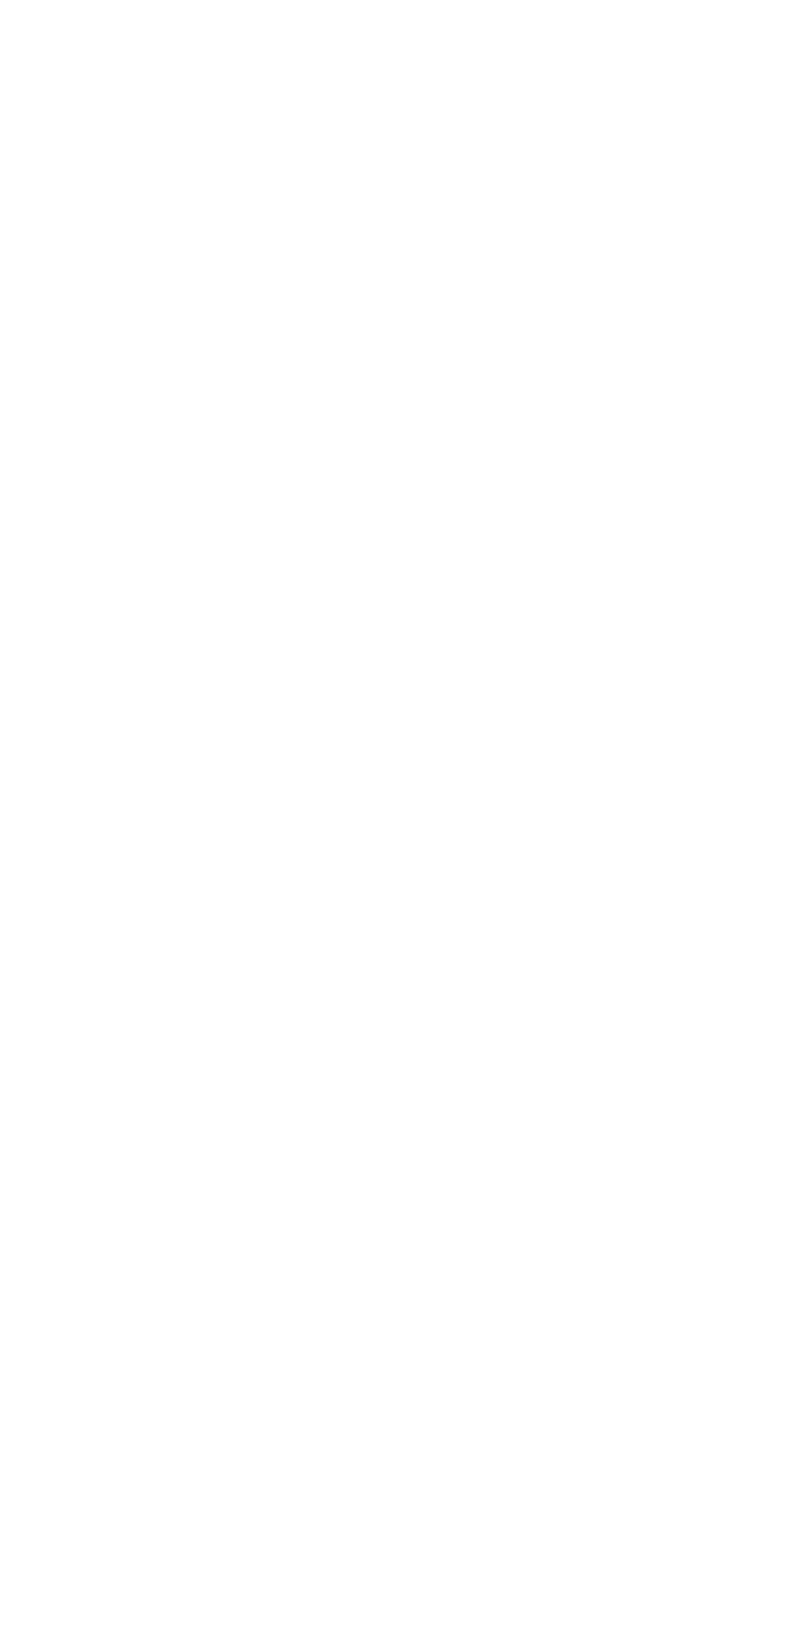

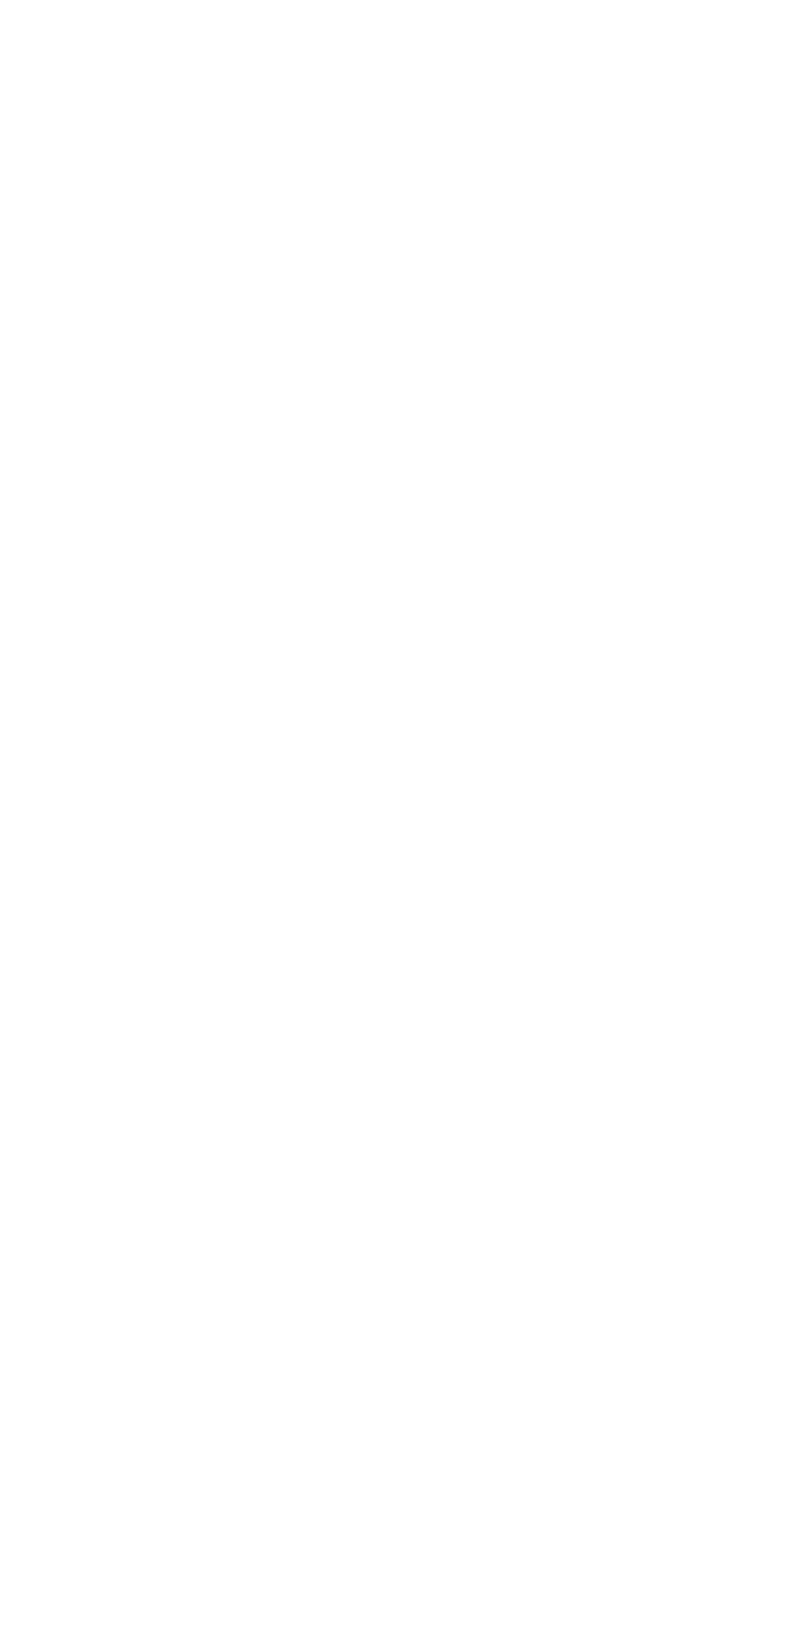

In [44]:
# AutoViz for EDA, run on a subset of the columns, too many columns will take too long, and may not be useful.
AV = AutoViz_Class()

autoviz_report = AV.AutoViz(
    filename=fname + '_subset.csv',
    sep=",",
    depVar="is_fraud",
    verbose=0
)

autoviz_report

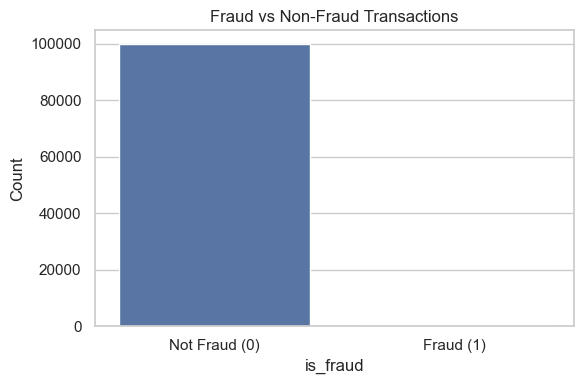

is_fraud
0    99.711
1     0.289
Name: proportion, dtype: float64
          gender        city_pop      acct_num         amt       \
count  100000.000000  1.000000e+05  1.000000e+05  100000.000000   
mean        0.482390  2.933952e+05  4.971789e+11      67.459051   
std         0.499692  5.648002e+05  2.895940e+11     164.191618   
min         0.000000  4.400000e+01  1.837412e+07       1.000000   
25%         0.000000  1.785300e+04  2.443508e+11       7.490000   
50%         0.000000  6.076300e+04  4.949888e+11      34.500000   
75%         1.000000  2.337170e+05  7.501972e+11      79.280000   
max         1.000000  2.906700e+06  9.999583e+11   11078.860000   

         distance     time_since_last_trans  
count  100000.000000      100000.000000      
mean       76.406411          74.770042      
std        29.269574          93.018155      
min         0.319967           0.000000      
25%        55.484537           4.850694      
50%        78.642078          44.513333      
75%     

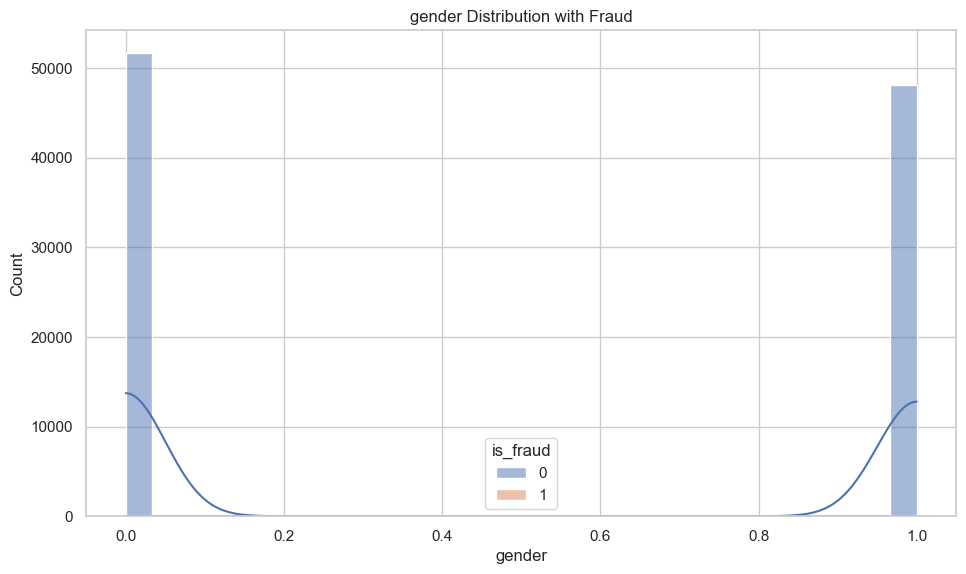

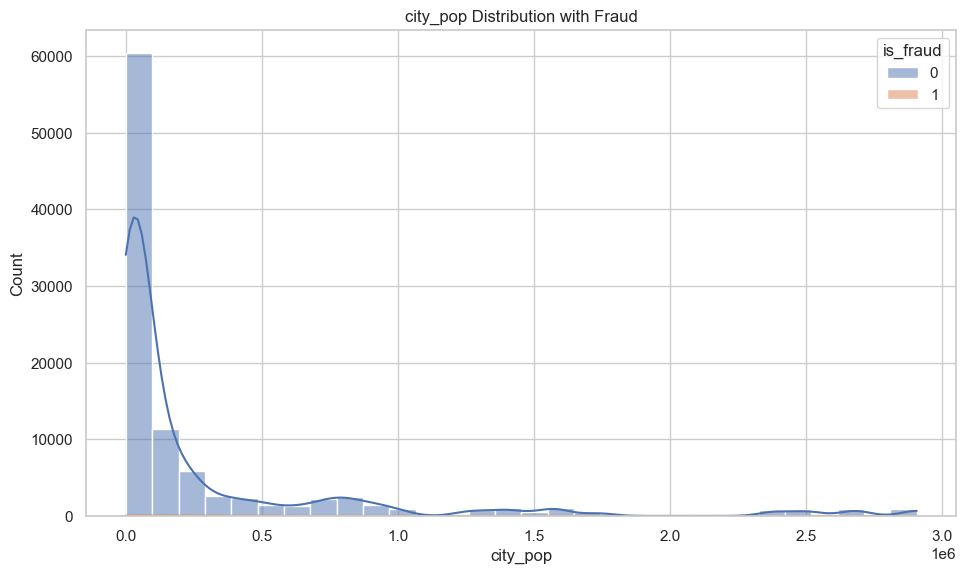

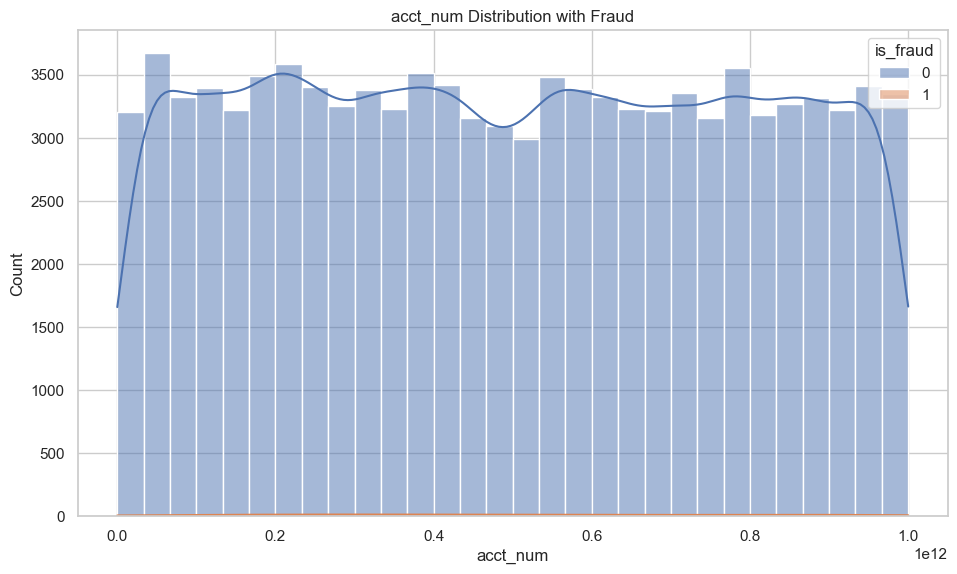

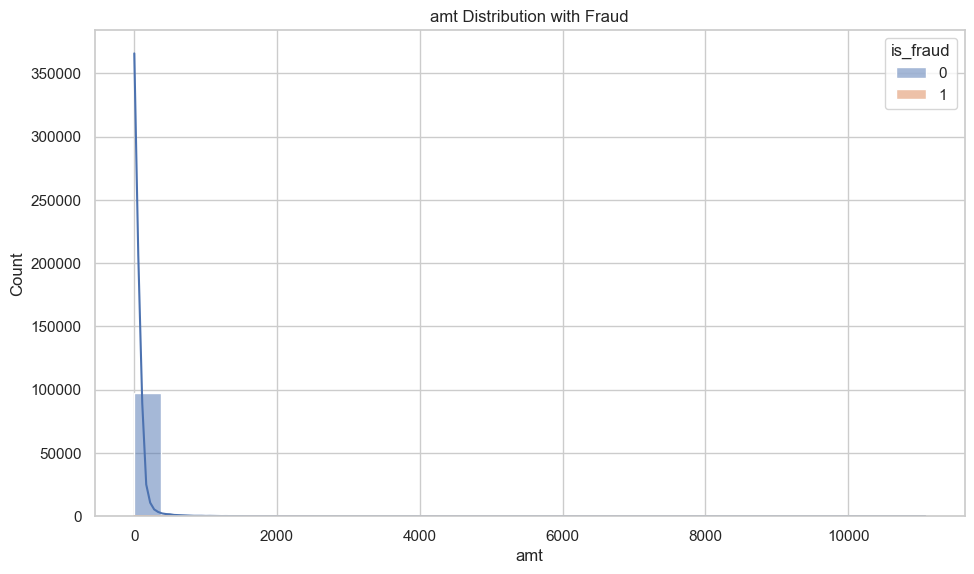

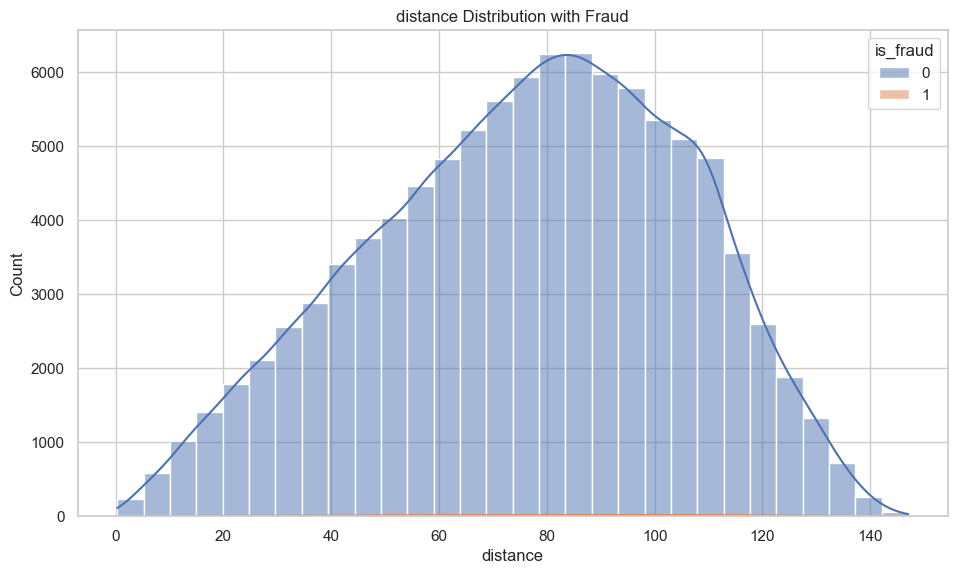

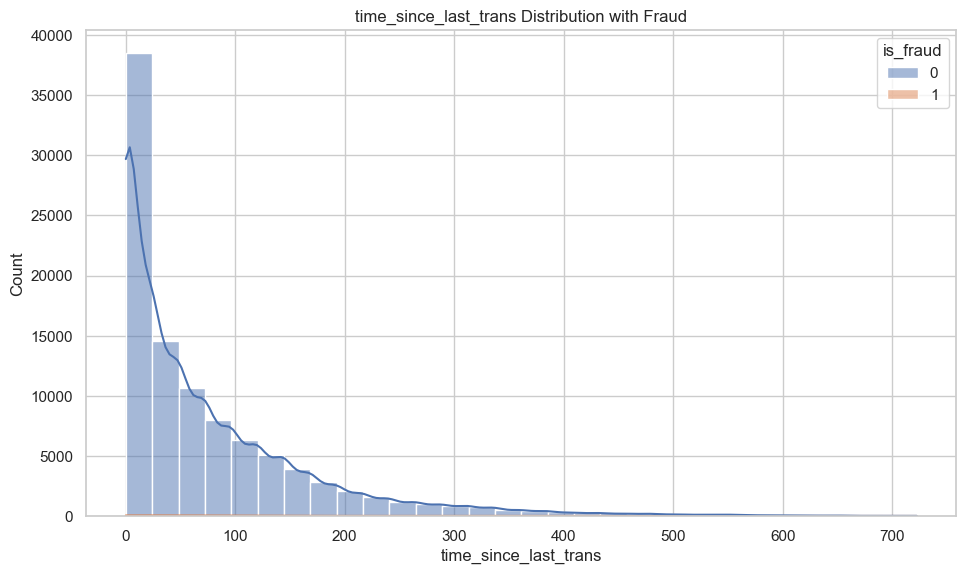

In [55]:
# Set plot style
sns.set(style="whitegrid")

df_tmp = df_eda[cols_of_interest]

# Distribution of the target variable
fraud_counts = df_tmp['is_fraud'].value_counts(normalize=True) * 100

# Basic statistics for numeric features
numeric_df = df_tmp.select_dtypes(include=['int64', 'float64'])
#desc_stats = 



# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=df_tmp)
plt.title('Fraud vs Non-Fraud Transactions')
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.xlabel('is_fraud')
plt.tight_layout()
plt.show()

print(fraud_counts)
print(numeric_df.describe())

for col in numeric_df.columns:
    plot_numerical(df_tmp, col)

**Key insights from AutoViz**

jjj

kkk

**Categorical Features EDA**

In [58]:
df_eda.head()   

id        ssn            cc_num        first      last    gender  \
38655  8123390  422-91-6327  3510694985435665  samantha  gonzalez     0     
75696  8123043  422-91-6327  3510694985435665  samantha  gonzalez     0     
32552  8122878  422-91-6327  3510694985435665  samantha  gonzalez     0     
93986  8123042  422-91-6327  3510694985435665  samantha  gonzalez     0     
70538  8122723  422-91-6327  3510694985435665  samantha  gonzalez     0     

                   street               city  state   zip     lat     long    \
38655  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
75696  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
32552  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
93986  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   
70538  16112_stanley_springs_apt._132  sidney   NE   69162  41.138 -102.9856   

       city_pop       job          dob      acct_num  \
38655    7765    energy_manager 1941-05-26  18374117   
75696    7765    energy_manager 1941-05-26  18374117   
32552    7765    energy_manager 1941-05-26  18374117   
93986    7765    energy_manager 1941-05-26  18374117   
70538    7765    energy_manager 1941-05-26  18374117   

                 profile                         trans_num              \
38655  adults_50up_female_urban.json  fe3b96184c6f0df6dc0e7167e2c690ad   
75696  adults_50up_female_urban.json  c55f6b59060f8ec42da7e497ccda2a85   
32552  adults_50up_female_urban.json  67cb71be8b60d59d21c45f4dc324cd37   
93986  adults_50up_female_urban.json  cf9972057d72b2a11e5e99816522828c   
70538  adults_50up_female_urban.json  a3fd6137233e2eb3e3fabba64a39f4da   

      trans_date      trans_time       unix_time    category       amt   \
38655 2019-12-08 1900-01-01 07:20:39  1575769839   shopping_pos    2.14   
75696 2019-12-11 1900-01-01 06:28:05  1576025885   shopping_pos    8.21   
32552 2019-12-11 1900-01-01 07:17:51  1576028871   shopping_pos    2.76   
93986 2019-12-18 1900-01-01 03:28:15  1576619895   shopping_pos    1.80   
70538 2019-12-22 1900-01-01 11:15:05  1576993505  entertainment  121.22   

       is_fraud               merchant               merch_lat  merch_long  \
38655      0     fraud_bahringer_schoen_and_corkery  40.496517 -102.800586   
75696      0       fraud_watsica_haag_and_considine  42.065814 -102.130644   
32552      0               fraud_stoltenberg-beatty  40.951743 -102.027276   
93986      0                      fraud_pouros-haag  40.860335 -102.522878   
70538      0         fraud_parker_nolan_and_trantow  41.371826 -103.963709   

       region   trans_day_of_week  is_weekend  trans_hour trans_time_segment  \
38655  Midwest          6               1           7         morning_6-12     
75696  Midwest          2               0           6         morning_6-12     
32552  Midwest          2               0           7         morning_6-12     
93986  Midwest          2               0           3       late_night_0-6     
70538  Midwest          6               1          11         morning_6-12     

       age age_group cc_type  area_cat   distance   time_since_last_trans  \
38655  78    senior   Unknown   urban    72.926922         0.000000         
75696  78    senior   Unknown   urban   125.293370        71.123889         
32552  78    senior   Unknown   urban    83.186257         0.829444         
93986  78    senior   Unknown   urban    49.663956       164.173333         
70538  78    senior   Unknown   urban    85.989781       103.780556         

        job_cat    
38655  Management  
75696  Management  
32552  Management  
93986  Management  
70538  Management

In [57]:
df_eda.columns

Index(['id', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num',
       'profile', 'trans_num', 'trans_date', 'trans_time', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'region', 'trans_day_of_week', 'is_weekend', 'trans_hour',
       'trans_time_segment', 'age', 'age_group', 'cc_type', 'area_cat',
       'distance', 'time_since_last_trans', 'job_cat'],
      dtype='object')

In [ ]:

# Select categorical features to test
cat_features = ['category', 'state', 'region', 'job_cat', 'cc_type', 'area_cat', 'trans_time_segment', 'age_group']
#add gender
#remove 'state'
#df_cat = df_eda[cat_features]

# Chi-square test results
chi2_results = []

for col in categorical_features:
    contingency_table = pd.crosstab(df_eda[col], df_eda['is_fraud'])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    chi2_results.append((col, p))

# pack chi results in DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'p_value']).sort_values(by='p_value')

# Plotting bar plots of top 4 significant categorical features
top_cats = chi2_df.head(8)['Feature'].tolist()



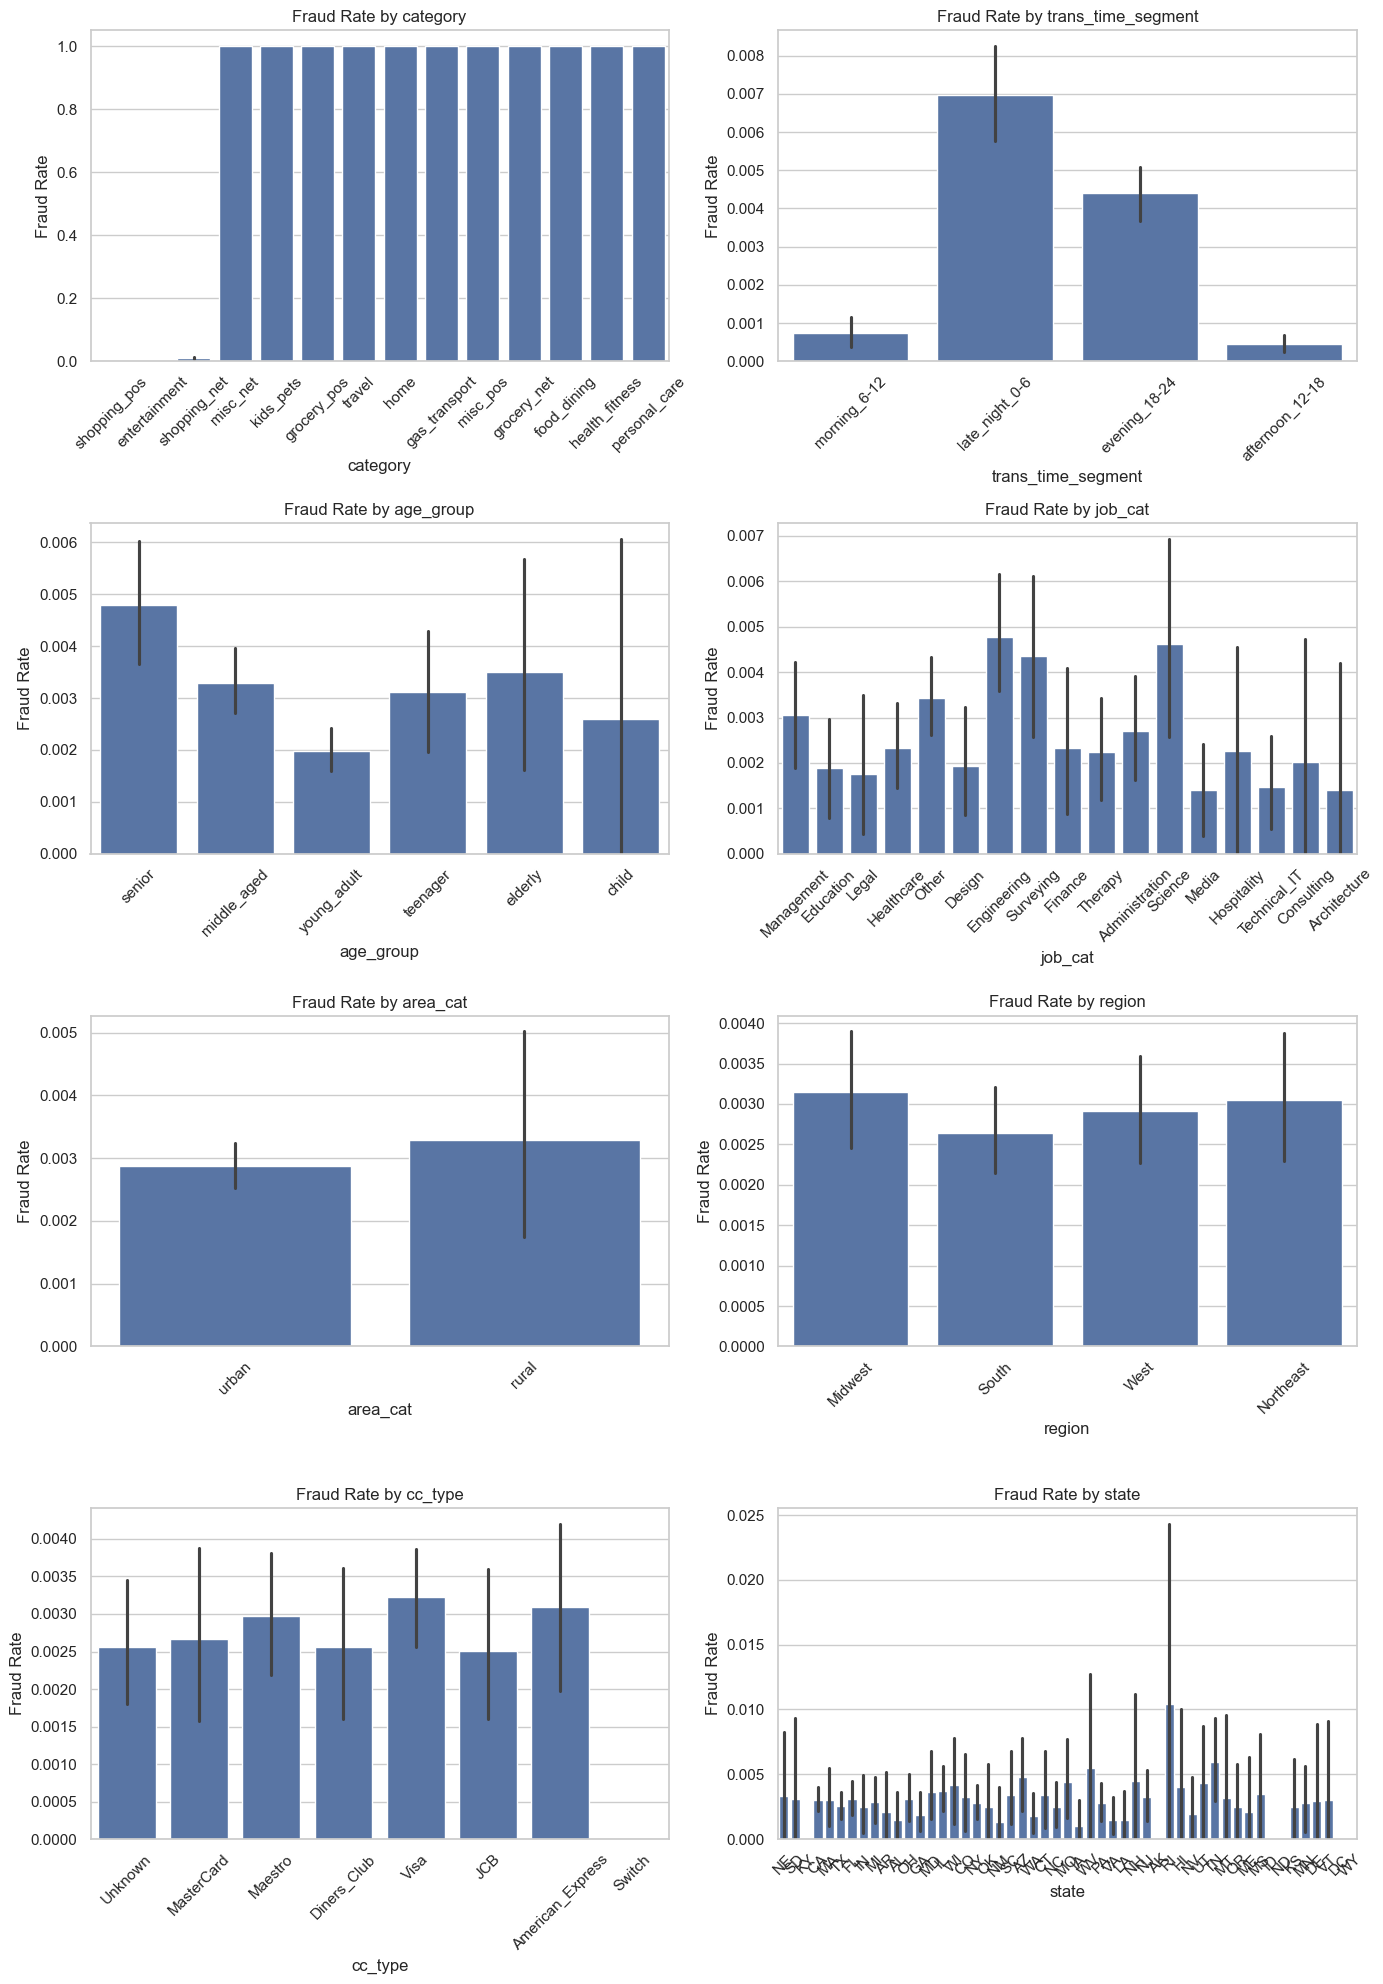

Feature           p_value  
0            category  0.000000e+00
6  trans_time_segment  4.601694e-47
7           age_group  1.208463e-05
3             job_cat  1.590417e-03
5            area_cat  6.854631e-01
2              region  6.858501e-01
4             cc_type  8.348006e-01
1               state  8.610985e-01

In [65]:
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
for i, col in enumerate(top_cats):
    ax = axes[i//2, i%2]
    sns.barplot(x=col, y='is_fraud', data=df_eda, ax=ax, estimator=lambda x: sum(x)/len(x))
    ax.set_title(f'Fraud Rate by {col}')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

chi2_df

*Insights from Chi-square test results*

**Numerical Features EDA**

In [67]:
df_eda.columns

Index(['id', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num',
       'profile', 'trans_num', 'trans_date', 'trans_time', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'region', 'trans_day_of_week', 'is_weekend', 'trans_hour',
       'trans_time_segment', 'age', 'age_group', 'cc_type', 'area_cat',
       'distance', 'time_since_last_trans', 'job_cat'],
      dtype='object')

In [70]:


# Filter fraud vs non-fraud subsets
is_fraud = df_eda[df_eda['is_fraud'] == 1]
not_fraud = df_eda[df_eda['is_fraud'] == 0]

# Numerical columns to test (excluding identifiers)
numerical_cols = [
    'amt', 'distance', 'time_since_last_trans', 'city_pop', 'trans_hour', 'age'
]

# Run t-tests and skewness
t_test_results = []
skewness = []

for col in numerical_cols:
    t_stat, p_val = ttest_ind(is_fraud[col], not_fraud[col], equal_var=False)
    t_test_results.append((col, p_val))
    skew_val = skew(df_eda[col])
    skewness.append((col, skew_val))

# Convert to DataFrames
ttest_df = pd.DataFrame(t_test_results, columns=['Feature', 'p_value']).sort_values(by='p_value')
skew_df = pd.DataFrame(skewness, columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False)

print(ttest_df)
print(skew_df)


         Feature             p_value  
0                    amt  5.269088e-51
5                    age  3.901587e-04
1               distance  1.660685e-01
2  time_since_last_trans  5.059123e-01
4             trans_hour  5.657375e-01
3               city_pop  6.101669e-01
         Feature          Skewness 
0                    amt  18.755993
3               city_pop   2.935516
2  time_since_last_trans   2.096488
5                    age   0.704009
1               distance  -0.236800
4             trans_hour  -0.447160


**Insights from Numerical EDA: T-Test & Skewness**  (working on changing datasets for performance reasons, exact markdown values may vary)

Differences in p-values  (Fraud vs Non-Fraud)

amt (p ≈ 1.8e-40): Strongly different — fraud transactions tend to involve much higher amounts.

age (p ≈ 0.003): Slightly significant — age groups differ in fraud susceptibility.


Not Significant (p > 0.05)

distance, city_pop, lat, long, trans_hour, time_since_last_trans

Skewness:

amt: Highly skewed (17.65) — log transformation recommended

city_pop: Skewed (2.93)

time_since_last_trans: Skewed (2.08)


**Study features with high skewness**

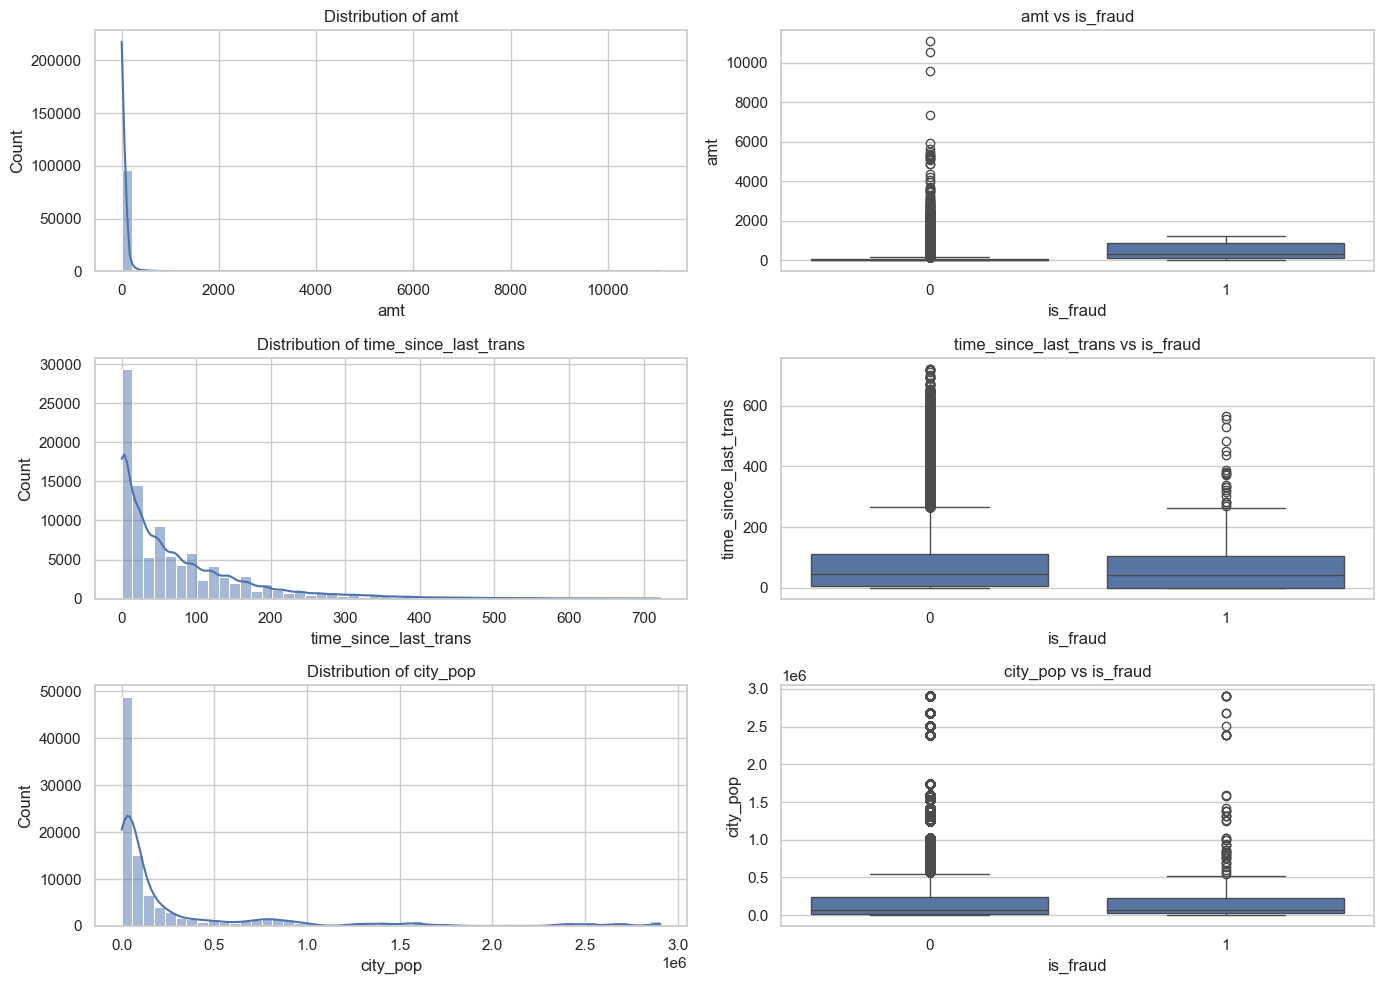

In [72]:
# Features with high skewness
skewed_features = ['amt', 'time_since_last_trans', 'city_pop']

# Plot distributions and boxplots
fig, axes = plt.subplots(len(skewed_features), 2, figsize=(14, 10))

for i, feature in enumerate(skewed_features):
    # Distribution plot
    sns.histplot(df_eda[feature], kde=True, ax=axes[i][0], bins=50)
    axes[i][0].set_title(f'Distribution of {feature}')
    
    # Boxplot by fraud status
    sns.boxplot(x='is_fraud', y=feature, data=df_eda, ax=axes[i][1])
    axes[i][1].set_title(f'{feature} vs is_fraud')

plt.tight_layout()
plt.show()

**Insights from Skewness & Outlier Visualization**

amt:
*   Highly right-skewed, long tail of high-value transactions.
*   Fraud transactions tend to involve larger amounts.
*   Log transformation recommended to normalize.

time_since_last_trans:
*   Right-skewed with many zeros and a long tail.
*   Fraud transactions aren't concentrated in one region — likely not useful alone, but may help in interaction features.

city_pop:
*   Skewed toward smaller populations.
*   No visible difference between fraud and non-fraud via boxplot.

**Action Items:
*   Handle Imbalance: Oversampling (SMOTE) or undersampling required before modeling.
*   Transform skewed features: Apply log1p() to *amt*, *city_pop*, and *time_since_last_trans*.
*   Consider Feature Engineering:
    *   Combine *trans_hour* with *is_weekend* or *category* for patterns.
    *   Create bins for *amt* or *distance* to simplify modeling.


**Apply log transformation on skewed features**

In [ ]:
skewed_cols = ['amt', 'time_since_last_trans', 'city_pop']
for col in skewed_cols:
    df_proc[f'log_{col}'] = np.log1p(df_proc[col]) # log transform the column to reduce skewness and normalize the distribution

**Show correlation between is_fraud and numerical features**

corr() uses Pearson correlation by default

In [95]:
df_eda['is_fraud'] = df_eda['is_fraud'].astype('int64')

In [97]:
df_corr = df_eda.select_dtypes(include=['int64', 'float64']).corr()
#sort absolute values to include negative correlations
target_corr = df_corr['is_fraud'].sort_values(ascending=False)


print(target_corr)

is_fraud                 1.000000
amt                      0.081075
gender                   0.005812
distance                 0.004552
cc_num                   0.001170
acct_num                 0.001137
merch_long               0.001113
long                     0.000948
city_pop                 0.000427
merch_lat               -0.000264
lat                     -0.000534
id                      -0.003518
time_since_last_trans   -0.010358
Name: is_fraud, dtype: float64


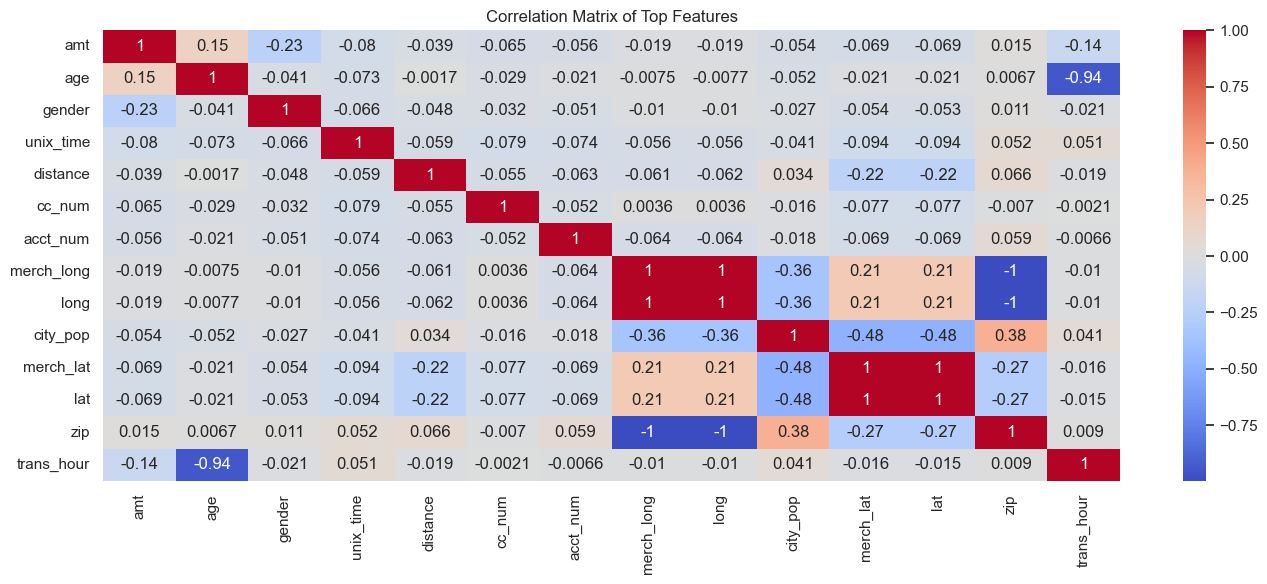

is_fraud      1.000000
amt           0.081075
age           0.012422
gender        0.005812
unix_time     0.004722
distance      0.004552
cc_num        0.001170
acct_num      0.001137
merch_long    0.001113
long          0.000948
Name: is_fraud, dtype: float64

In [94]:
# Plot heatmap of top correlated numerical features with is_fraud
top_corr_features = target_corr[1:15].index  # Skip is_fraud itself
plt.figure(figsize=(14, 6))
sns.heatmap(df_corr[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Top Features")
plt.tight_layout()
plt.show()

target_corr.head(10)

**Feature Importance**

using ramdom forest

In [102]:
df_eda.columns

Index(['id', 'ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city',
       'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num',
       'profile', 'trans_num', 'trans_date', 'trans_time', 'unix_time',
       'category', 'amt', 'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'region', 'trans_day_of_week', 'is_weekend', 'trans_hour',
       'trans_time_segment', 'age', 'age_group', 'cc_type', 'area_cat',
       'distance', 'time_since_last_trans', 'job_cat'],
      dtype='object')

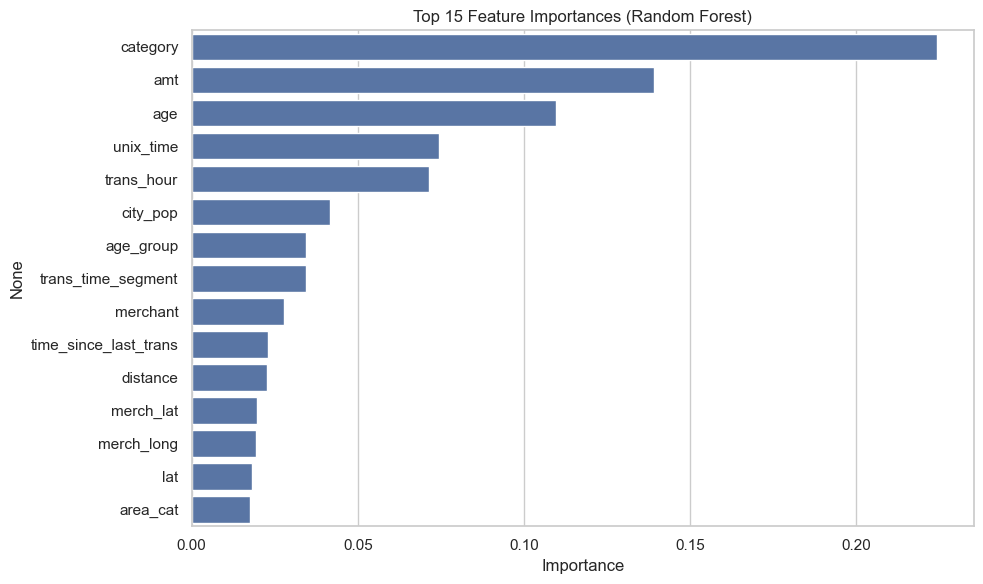

category                 0.224155
amt                      0.139019
age                      0.109571
unix_time                0.074388
trans_hour               0.071293
city_pop                 0.041666
age_group                0.034438
trans_time_segment       0.034290
merchant                 0.027640
time_since_last_trans    0.022925
distance                 0.022784
merch_lat                0.019608
merch_long               0.019311
lat                      0.018185
area_cat                 0.017681
dtype: float64

In [101]:
 
df_model = df_eda.copy()

# Encode categorical variables
categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

# Define features and target
X = df_model.drop(columns=['is_fraud', 'ssn', 'id', 'cc_num', 'acct_num', 'trans_num', 'profile', 'trans_date', 'trans_time', 'dob', 'street', 'first', 'last'])
y = df_model['is_fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train a random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

importances.head(15)